In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [51]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [4]:
print('Data shape: {}'.format(epoch_data.shape))

Data shape: (17998, 21, 170, 1)


In [5]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [6]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

In [52]:
subject_name = 'SubjectF'
epoch_data, epoch_label = retrieve_data(subject_name)

In [11]:
def add_noise(data, std_dev, mean = 0):
    noise = np.random.normal(mean, std_dev, size = data.shape)
    new_data = data + noise
    return new_data

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(epoch_data, epoch_label, test_size = 0.1,
                                                                    random_state = 42, stratify = epoch_label)
print('Train data shape: {}'.format(train_data.shape))
print('Test data shape: {}'.format(test_data.shape))

In [13]:
def create_cnn(input_shape, optimizer = None):
    conv1_init = tf.keras.initializers.GlorotUniform(42)
    conv2_init = tf.keras.initializers.GlorotUniform(42)
    dense1_init = tf.keras.initializers.GlorotUniform(24)
    dense2_init = tf.keras.initializers.GlorotUniform(24)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                               activation = 'relu', kernel_initializer = conv1_init),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = 'relu',
                               kernel_initializer = conv2_init),
        tf.keras.layers.AveragePooling2D(pool_size = (1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = dense1_init),
        tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
    ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [ ]:
# strat_kfold = StratifiedKFold(n_splits = 10)

In [ ]:
n_classes = len(np.unique(train_labels))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = n_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = n_classes)

In [15]:
model = create_cnn(input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3]))
history = model.fit(train_data, train_labels, batch_size = 16, validation_data = (test_data, test_labels),
                    epochs = 20)

Epoch 1/20
107/107 [==============================] - 11s 98ms/step - loss: 1.7223 - accuracy: 0.2649 - val_loss: 1.5497 - val_accuracy: 0.3874
Epoch 2/20
107/107 [==============================] - 9s 82ms/step - loss: 1.3509 - accuracy: 0.4234 - val_loss: 1.3972 - val_accuracy: 0.4136
Epoch 3/20
107/107 [==============================] - 9s 80ms/step - loss: 1.1886 - accuracy: 0.5135 - val_loss: 1.3703 - val_accuracy: 0.3770
Epoch 4/20
107/107 [==============================] - 9s 83ms/step - loss: 1.0792 - accuracy: 0.5725 - val_loss: 1.3223 - val_accuracy: 0.4031
Epoch 5/20
107/107 [==============================] - 9s 82ms/step - loss: 0.9848 - accuracy: 0.6047 - val_loss: 1.3052 - val_accuracy: 0.4031
Epoch 6/20
107/107 [==============================] - 9s 83ms/step - loss: 0.9038 - accuracy: 0.6474 - val_loss: 1.3134 - val_accuracy: 0.4555
Epoch 7/20
107/107 [==============================] - 9s 85ms/step - loss: 0.8428 - accuracy: 0.6772 - val_loss: 1.3092 - val_accuracy: 0.418

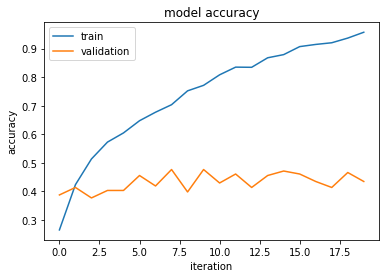

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Hasil/noise_addition.png')
plt.show()

In [53]:
acc_scores = []
prec_scores, rec_scores = [], []
std_devs = [0.5, 0.6]
strat_kfold = StratifiedKFold(n_splits = 10)
for train_index, test_index in strat_kfold.split(epoch_data, epoch_label):
    train_data, test_data = epoch_data[train_index], epoch_data[test_index]
    train_labels, test_labels = epoch_label[train_index], epoch_label[test_index]
    copy_data = train_data.copy()
    train_data, train_labels = list(train_data), list(train_labels)
    for index, data in enumerate(copy_data):
        for dev in std_devs:
            train_data.append(add_noise(data, std_dev = dev))
            train_labels.append(train_labels[index])
    train_data, train_labels = np.array(train_data), np.array(train_labels)
    print('Train data shape after noise addition: {}'.format(train_data.shape))
    shuffled_indices = np.arange(train_data.shape[0])
    np.random.shuffle(shuffled_indices)
    train_data = train_data[shuffled_indices]
    train_labels = train_labels[shuffled_indices]
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = len(np.unique(train_labels)))
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = len(np.unique(test_labels)))
    
    model = create_cnn(input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3]))
    history = model.fit(train_data, train_labels, batch_size = 16, validation_data = (test_data, test_labels),
                        epochs = 20)
    _, acc = model.evaluate(test_data, test_labels)
    predictions = model.predict(test_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    real_labels = np.array([np.argmax(label) for label in test_labels])
    acc_scores.append(acc)
    prec_scores.append(precision_score(predictions, real_labels, average = 'weighted'))
    rec_scores.append(recall_score(predictions, real_labels, average = 'weighted'))

Train data shape after noise addition: (7758, 21, 170, 1)
Epoch 1/20
485/485 [==============================] - 23s 48ms/step - loss: 1.4439 - accuracy: 0.3743 - val_loss: 1.3993 - val_accuracy: 0.3993
Epoch 2/20
485/485 [==============================] - 25s 52ms/step - loss: 0.9719 - accuracy: 0.6196 - val_loss: 1.3301 - val_accuracy: 0.4861
Epoch 3/20
485/485 [==============================] - 26s 53ms/step - loss: 0.6886 - accuracy: 0.7593 - val_loss: 1.3750 - val_accuracy: 0.5035
Epoch 4/20
485/485 [==============================] - 27s 56ms/step - loss: 0.5021 - accuracy: 0.8422 - val_loss: 1.4183 - val_accuracy: 0.4861
Epoch 5/20
485/485 [==============================] - 27s 55ms/step - loss: 0.3569 - accuracy: 0.9037 - val_loss: 1.6226 - val_accuracy: 0.5208
Epoch 6/20
485/485 [==============================] - 27s 55ms/step - loss: 0.2475 - accuracy: 0.9491 - val_loss: 1.6981 - val_accuracy: 0.5000
Epoch 7/20
485/485 [==============================] - 26s 54ms/step - loss: 0.

486/486 [==============================] - 32s 66ms/step - loss: 0.1094 - accuracy: 0.9911 - val_loss: 2.6082 - val_accuracy: 0.3763
Epoch 9/20
486/486 [==============================] - 33s 67ms/step - loss: 0.0708 - accuracy: 0.9970 - val_loss: 2.8767 - val_accuracy: 0.3902
Epoch 10/20
486/486 [==============================] - 33s 69ms/step - loss: 0.0623 - accuracy: 0.9946 - val_loss: 2.9029 - val_accuracy: 0.3902
Epoch 11/20
486/486 [==============================] - 34s 70ms/step - loss: 0.0299 - accuracy: 0.9999 - val_loss: 3.1407 - val_accuracy: 0.3833
Epoch 12/20
486/486 [==============================] - 34s 70ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 3.2812 - val_accuracy: 0.3902
Epoch 13/20
486/486 [==============================] - 35s 72ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 3.5007 - val_accuracy: 0.3868
Epoch 14/20
486/486 [==============================] - 35s 71ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 3.6736 - val_accuracy: 0.393

In [54]:
df_stddev = pd.DataFrame({'Accuracy': acc_scores, 'Precision': prec_scores, 'Recall': rec_scores})
df_stddev.to_csv('Hasil/CV_NA_{}.csv'.format(subject_name))

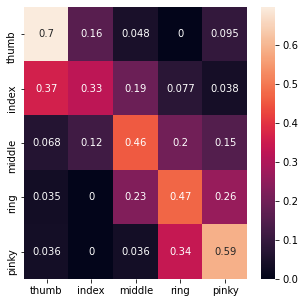

In [55]:
label = ['thumb', 'index', 'middle', 'ring', 'pinky']
cm = confusion_matrix(real_labels, predictions, normalize = 'true')
df_cm = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot = True)
plt.savefig('Hasil/CM_{}_NA.png'.format(subject_name), facecolor = 'w', edgecolor = 'w')
plt.show()